# Traffic Sign Detection

In this final assignment the task is not only to classify traffic signs but to locate them beforehand in the
whole image, so a detection task is added. The followed approach was based on Faster R-CNN, in which
we have to follow two stages. First we had to predict class-agnostic bounding box proposals using a
Region Proposal Network (RPN) and then classify and fine-regress location of boxes. In order to classify
we could use the information for the previous assignments as the object to categorize is the same: traffic
signs.

The RPN was already provided so our focus was in discarding bounding boxes that were not traffic
signs. However, apart from that we hypertuned the parameters for the RPN in order to generate shapes
that were adequate and in line with our ground truth. As previously explained in the description of the
detection dataset GTSDB (1.2.1) the traffic signs could appear in sizes from 16x16 to 128x128 and the
shape was almost squared, so this data was useful in order to choose the best parameters for the RPN.

# Imports

In [ ]:
!pip install opencv-python
!pip install matplotlib
!pip install sklearn

import numpy as np
import cv2
import csv
import matplotlib.pyplot as plt
%matplotlib inline 
from sklearn.utils import shuffle
import random

%tensorflow_version 2.x
import tensorflow as tf
import tensorflow.compat.v1 as tf1
import os

# tf1.disable_v2_behavior()

import tensorflow.keras
import tensorflow.keras.backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, Input, Activation, Lambda
from tensorflow.keras.layers import BatchNormalization, GlobalMaxPooling2D, MaxPooling2D, ZeroPadding2D, Add, Conv2D
from tensorflow.keras.models import Model, Sequential

from tensorflow.keras import optimizers
from time import time
from statistics import mean, median

# Assignment 2.3: Traffic Sign Detection

In [ ]:
IMAGE_SIZE = (32, 32)

## Method to read images

In [ ]:
IMG_HEIGHT = 600

# Function for reading the images
def readImages(rootpath, images_range, signs_range):
    '''Reads traffic sign data for German Traffic Sign Recognition Benchmark.
    Arguments: path to the traffic sign data, for example 'FullIJCNN2013'
    Returns:   list of images, list of corresponding labels'''
    images = {} # original image
    scales = {} # original scale
    for num in images_range:
        filename = rootpath + '/' + "{:05d}".format(num) + '.ppm'
        img = cv2.imread(filename, cv2.IMREAD_COLOR)
        scale = IMG_HEIGHT / float(img.shape[0])
        img_resized = cv2.resize(img, (int(img.shape[1]*scale),int(img.shape[0]*scale)))
        images.setdefault(filename,[]).append(img_resized)
        scales.setdefault(filename,[]).append(scale)

    files = [] # filenames
    signs = [] # traffic sign image
    bboxes = [] # corresponding box detection
    labels = [] # traffic sign type
    data = np.genfromtxt(rootpath + '/' + 'gt.txt', delimiter=';', dtype=str, usecols=range(0, 6))
    for elem in signs_range:
        filename = rootpath + '/' + data[elem][0]
        img = images.get(filename)[0]
        scale = scales.get(filename)[0]
        bbox = np.array([int(data[elem][1]), int(data[elem][2]), int(data[elem][3]), int(data[elem][4])]) * scale
        sign = img[int(bbox[1]):int(bbox[3]), int(bbox[0]):int(bbox[2])]
        sign_resized = cv2.resize(sign, IMAGE_SIZE)
        files.append(filename)
        signs.append(sign_resized)
        bboxes.append(bbox)
        labels.append(data[elem][5])
    return images, files, signs, bboxes, labels

## Get German Traffic Sign Recognition Benchmark Data
Download full data set from http://www.dia.fi.upm.es/~lbaumela/FullIJCNN2013.zip

In [ ]:
!wget -c http://www.dia.fi.upm.es/~lbaumela/FullIJCNN2013.zip
!unzip FullIJCNN2013.zip

--2020-04-03 20:04:10--  http://www.dia.fi.upm.es/~lbaumela/FullIJCNN2013.zip
Resolving www.dia.fi.upm.es (www.dia.fi.upm.es)... 138.100.11.29
Connecting to www.dia.fi.upm.es (www.dia.fi.upm.es)|138.100.11.29|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1661866983 (1.5G) [application/zip]
Saving to: ‘FullIJCNN2013.zip’

FullIJCNN2013.zip   100%[===================>]   1.55G  11.2MB/s    in 2m 23s  

2020-04-03 20:06:34 (11.1 MB/s) - ‘FullIJCNN2013.zip’ saved [1661866983/1661866983]

Archive:  FullIJCNN2013.zip
   creating: FullIJCNN2013/
   creating: FullIJCNN2013/00/
  inflating: FullIJCNN2013/00000.ppm  
  inflating: FullIJCNN2013/00001.ppm  
  inflating: FullIJCNN2013/00002.ppm  
  inflating: FullIJCNN2013/00003.ppm  
  inflating: FullIJCNN2013/00004.ppm  
  inflating: FullIJCNN2013/00005.ppm  
  inflating: FullIJCNN2013/00006.ppm  
  inflating: FullIJCNN2013/00007.ppm  
  inflating: FullIJCNN2013/00008.ppm  
  inflating: FullIJCNN2013/00009.ppm  
  infla

In [ ]:
train_images, train_files, train_signs, train_bboxes, train_labels = readImages('FullIJCNN2013', range(0,600), range(0,852))
test_images, test_files, test_signs, test_bboxes, test_labels = readImages('FullIJCNN2013', range(600,900), range(852,1213))

## Process Data

In [ ]:
num_classes = 43
train_files, train_signs, train_bboxes, train_labels = shuffle(train_files, train_signs, train_bboxes, train_labels)

# Data pre-processing
tr_signs = np.array(train_signs)[0:600]
tr_labels = np.array(train_labels)[0:600]
va_signs = np.array(train_signs)[600:852]
va_labels = np.array(train_labels)[600:852]
te_signs = np.array(test_signs)
te_labels = np.array(test_labels)

tr_signs = tr_signs.astype('float32')
va_signs = va_signs.astype('float32')
te_signs = te_signs.astype('float32')
tr_signs /= 255.0
va_signs /= 255.0
te_signs /= 255.0

tr_labels = to_categorical(tr_labels, num_classes)
va_labels = to_categorical(va_labels, num_classes)
te_labels = to_categorical(te_labels, num_classes)

## Show examples from each class

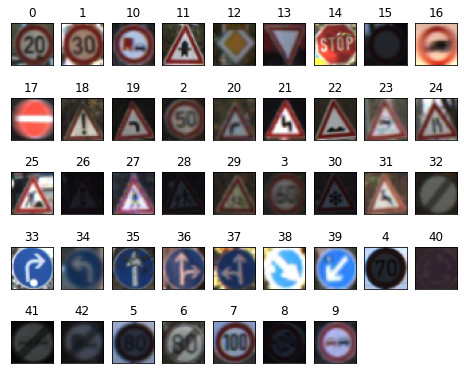

In [ ]:
class_names = np.unique(train_labels)
num_classes = len(class_names)
fig = plt.figure(figsize=(8,8))
for i in range(num_classes):
    ax = fig.add_subplot(6, 9, 1 + i, xticks=[], yticks=[])
    ax.set_title(class_names[i])
    indices = np.where(np.isin(train_labels, class_names[i]))[0]
    plt.imshow(cv2.cvtColor(train_signs[int(np.random.choice(indices, 1))], cv2.COLOR_BGR2RGB))
plt.show()

## Show heatmap of ground truth in train

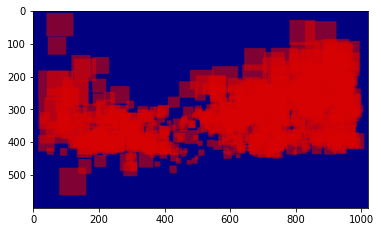

In [ ]:
heatmap = np.zeros([600, 1020, 3], np.uint8)
heatmap[:] = (0, 0, 128)

for filename in train_images:
    # Draw ground truth
    if filename in train_files:
        for idx in [i for i, x in enumerate(train_files) if x == filename]:
            bbox = train_bboxes[idx]

            traffic_sign = heatmap[int(bbox[1]):int(bbox[3]), int(bbox[0]):int(bbox[2])]

            black_rect = np.zeros(traffic_sign.shape, np.uint8)
            black_rect[:] = (255, 0, 0)

            res = cv2.addWeighted(traffic_sign, 0.4, black_rect, 0.5, 1.0)
            heatmap[int(bbox[1]):int(bbox[3]), int(bbox[0]):int(bbox[2])] = res

            # cv2.rectangle(temp, (int(bbox[0]),int(bbox[1])), (int(bbox[2]),int(bbox[3])), (255, 0, 0), cv2.FILLED)

plt.imshow(heatmap)

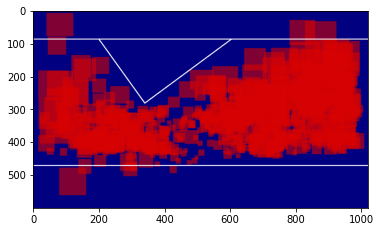

In [ ]:
heatmap_lines = heatmap.copy()

MIN_Y = 85
MAX_Y = 470

RECT_POINT_1_X = 200
RECT_POINT_2_X = 340
RECT_POINT_2_Y = 280
RECT_POINT_3_X = 604

cv2.line(heatmap_lines, (0, MIN_Y), (1020, MIN_Y), (255, 255, 255), 2)
cv2.line(heatmap_lines, (0, MAX_Y), (1020, MAX_Y), (255, 255, 255), 2)

cv2.line(heatmap_lines, (RECT_POINT_1_X, MIN_Y), (RECT_POINT_2_X, RECT_POINT_2_Y), (255, 255, 255), 2)
cv2.line(heatmap_lines, (RECT_POINT_2_X, RECT_POINT_2_Y), (RECT_POINT_3_X, MIN_Y), (255, 255, 255), 2)

plt.imshow(heatmap_lines)

## Formula to see if image  is valid

In [ ]:
# https://huse360.home.blog/2019/12/14/como-saber-si-un-punto-esta-dentro-de-un-triangulo/
def isPointInside(point):
  pointA = (RECT_POINT_1_X, MIN_Y)
  pointB = (RECT_POINT_2_X, RECT_POINT_2_Y)
  pointC = (RECT_POINT_3_X, MIN_Y + 0.1)

  pointD = (pointB[0] - pointA[0], pointB[1] - pointA[1])
  pointE = (pointC[0] - pointA[0], pointC[1] - pointA[1])

  w1 = (pointE[0] * (pointA[1] - point[1]) + pointE[1] * (point[0] - pointA[0])) / (pointD[0] * pointE[1] - pointD[1] * pointE[0])
  w2 = (point[1] - pointA[1] - w1 * pointD[1]) / pointE[1]

  inside = (w1 >= 0.0) and (w2 >= 0.0) and ((w1 + w2) <= 1.0)

  return inside


def isPointValid(point):
  return not isPointInside(point) and point[1] > MIN_Y and point[1] < MAX_Y


# Coordinates: [upper_left_x, upper_left_y, bottom_right_x, bottom_right_y]
# leftTopPoint = (upper_left_x, upper_left_y)
# rightBotPoint = (bottom_right_x, bottom_right_y)
def hasValidSize(leftTopPoint, rightBotPoint, min_size, max_size, max_ratio):
  width = rightBotPoint[0] - leftTopPoint[0]
  height = rightBotPoint[1] - leftTopPoint[1]

  return width >= min_size and width <= max_size and height >= min_size and height <= max_size and (width / height) <= max_ratio and (height / width) <= max_ratio

# Coordinates: [upper_left_x, upper_left_y, bottom_right_x, bottom_right_y]
def isBoxValid(coordinates, min_size, max_size, max_ratio, verbose = 0):
  leftTopPoint = (coordinates[0], coordinates[1])
  leftBotPoint = (coordinates[0], coordinates[3])
  rightTopPoint = (coordinates[2], coordinates[1])
  rightBotPoint =  (coordinates[2], coordinates[3])

  # Our restriction is that at least 3 points are inside
  valid_points = 0
  valid_points += 1 if isPointValid(leftTopPoint) else 0
  valid_points += 1 if isPointValid(leftBotPoint) else 0
  valid_points += 1 if isPointValid(rightTopPoint) else 0
  valid_points += 1 if isPointValid(rightBotPoint) else 0

  if (verbose > 0):
    print(valid_points)
    print(hasValidSize(leftTopPoint, rightBotPoint, min_size, max_size, max_ratio))

  return valid_points >=3 and hasValidSize(leftTopPoint, rightBotPoint, min_size, max_size, max_ratio)

False


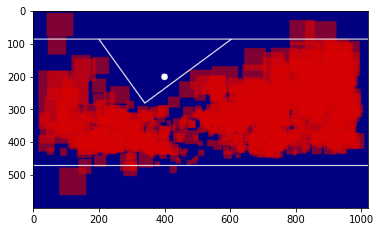

In [ ]:
heatmap_point_1 = heatmap_lines.copy()
point = (400, 200)

cv2.circle(heatmap_point_1, point, 10, (255, 255, 255), -1) 
plt.imshow(heatmap_point_1)

print(isPointValid(point))

True


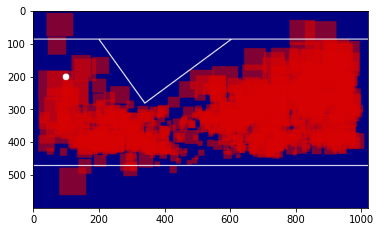

In [ ]:
heatmap_point_1 = heatmap_lines.copy()
point = (100, 200)

cv2.circle(heatmap_point_1, point, 10, (255, 255, 255), -1) 
plt.imshow(heatmap_point_1)

print(isPointValid(point))

False


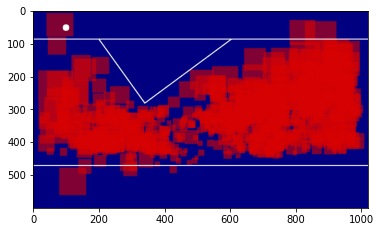

In [ ]:
heatmap_point_1 = heatmap_lines.copy()
point = (100, 50)

cv2.circle(heatmap_point_1, point, 10, (255, 255, 255), -1) 
plt.imshow(heatmap_point_1)

print(isPointValid(point))

False


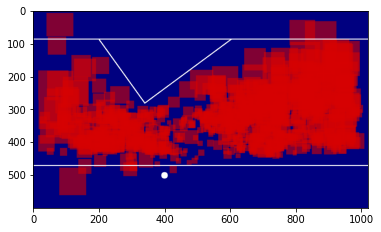

In [ ]:
heatmap_point_1 = heatmap_lines.copy()
point = (400, 500)

cv2.circle(heatmap_point_1, point, 10, (255, 255, 255), -1) 
plt.imshow(heatmap_point_1)

print(isPointValid(point))

2
True
False


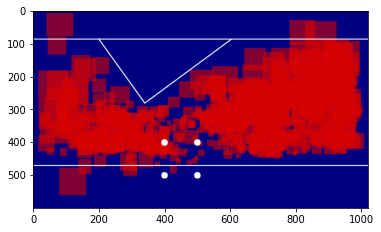

In [ ]:
heatmap_point_1 = heatmap_lines.copy()
leftTopPoint = (400, 400)
leftBotPoint = (400, 500)
rightTopPoint = (500, 400)
rightBotPoint = (500, 500)

cv2.circle(heatmap_point_1, leftTopPoint, 10, (255, 255, 255), -1) 
cv2.circle(heatmap_point_1, leftBotPoint, 10, (255, 255, 255), -1) 
cv2.circle(heatmap_point_1, rightTopPoint, 10, (255, 255, 255), -1) 
cv2.circle(heatmap_point_1, rightBotPoint, 10, (255, 255, 255), -1) 
plt.imshow(heatmap_point_1)

print(isBoxValid([leftTopPoint[0], leftTopPoint[1], rightBotPoint[0], rightBotPoint[1]], 10, 200, 1.2, verbose=1))

4
True
True


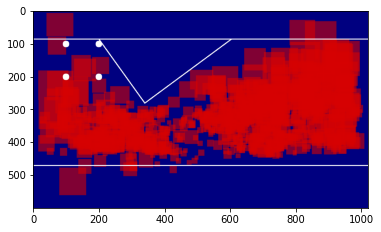

In [ ]:
heatmap_point_1 = heatmap_lines.copy()
leftTopPoint = (100, 100)
leftBotPoint = (100, 200)
rightTopPoint = (200, 100)
rightBotPoint = (200, 200)

cv2.circle(heatmap_point_1, leftTopPoint, 10, (255, 255, 255), -1) 
cv2.circle(heatmap_point_1, leftBotPoint, 10, (255, 255, 255), -1) 
cv2.circle(heatmap_point_1, rightTopPoint, 10, (255, 255, 255), -1) 
cv2.circle(heatmap_point_1, rightBotPoint, 10, (255, 255, 255), -1) 
plt.imshow(heatmap_point_1)

print(isBoxValid([leftTopPoint[0], leftTopPoint[1], rightBotPoint[0], rightBotPoint[1]], 10, 200, 1.2, verbose=1))

3
True
True


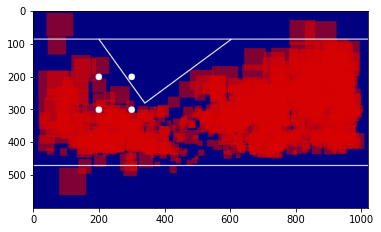

In [ ]:
heatmap_point_1 = heatmap_lines.copy()
leftTopPoint = (200, 200)
leftBotPoint = (200, 300)
rightTopPoint = (300, 200)
rightBotPoint = (300, 300)

cv2.circle(heatmap_point_1, leftTopPoint, 10, (255, 255, 255), -1) 
cv2.circle(heatmap_point_1, leftBotPoint, 10, (255, 255, 255), -1) 
cv2.circle(heatmap_point_1, rightTopPoint, 10, (255, 255, 255), -1) 
cv2.circle(heatmap_point_1, rightBotPoint, 10, (255, 255, 255), -1) 
plt.imshow(heatmap_point_1)

print(isBoxValid([leftTopPoint[0], leftTopPoint[1], rightBotPoint[0], rightBotPoint[1]], 10, 200, 1.2, verbose=1))

2
True
False


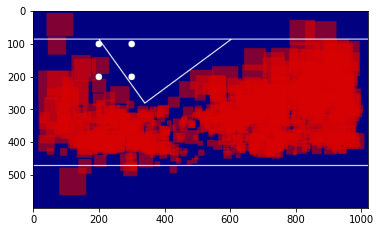

In [ ]:
heatmap_point_1 = heatmap_lines.copy()
leftTopPoint = (200, 100)
leftBotPoint = (200, 200)
rightTopPoint = (300, 100)
rightBotPoint = (300, 200)

cv2.circle(heatmap_point_1, leftTopPoint, 10, (255, 255, 255), -1) 
cv2.circle(heatmap_point_1, leftBotPoint, 10, (255, 255, 255), -1) 
cv2.circle(heatmap_point_1, rightTopPoint, 10, (255, 255, 255), -1) 
cv2.circle(heatmap_point_1, rightBotPoint, 10, (255, 255, 255), -1) 
plt.imshow(heatmap_point_1)

print(isBoxValid([leftTopPoint[0], leftTopPoint[1], rightBotPoint[0], rightBotPoint[1]], 10, 200, 1.2, verbose=1))

# Assignment 3.4: Traffic sign detection

First of all pre present an implementation of Faster-RCNN from:

> S. Ren, K. He, R. Girshick and J. Sun, "Faster R-CNN: Towards Real-Time Object Detection with Region Proposal Networks," in IEEE Transactions on Pattern Analysis and Machine Intelligence, vol. 39, no. 6, pp. 1137-1149, 1 June 2017.

The implementation uses as backbone the ResNet. We provide the pre-trained weights of both, the backbone and the region proposal network.

## Utils

In [ ]:
from tensorflow.keras.applications import MobileNetV2

def get_traffic_sign_model(input_shape, num_classes):
   model = Sequential([
      MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet'),
      GlobalMaxPooling2D(),
      Dense(num_classes, activation='softmax')
   ])
   return model

In [ ]:
"""Operations for [N, 4] numpy arrays representing bounding boxes.
Example box operations that are supported:
  * Areas: compute bounding box areas
  * IOU: pairwise intersection-over-union scores
"""
def area(boxes):
    """Computes area of boxes.
    Args:
    boxes: Numpy array with shape [N, 4] holding N boxes
    Returns:
    a numpy array with shape [N*1] representing box areas
    """
    return (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])

def custom_area(box):
    """Computes area of boxes.
    Args:
    boxes: Numpy array with shape [N, 4] holding N boxes
    Returns:
    a numpy array with shape [N*1] representing box areas
    """
    return (box[2] - box[0]) * (box[3] - box[1])

def intersection(boxes1, boxes2):
    """Compute pairwise intersection areas between boxes.
    Args:
    boxes1: a numpy array with shape [N, 4] holding N boxes
    boxes2: a numpy array with shape [M, 4] holding M boxes
    Returns:
    a numpy array with shape [N*M] representing pairwise intersection area
    """
    [x_min1, y_min1, x_max1, y_max1] = np.split(boxes1, 4, axis=1)
    [x_min2, y_min2, x_max2, y_max2] = np.split(boxes2, 4, axis=1)
    all_pairs_min_ymax = np.minimum(y_max1, np.transpose(y_max2))
    all_pairs_max_ymin = np.maximum(y_min1, np.transpose(y_min2))
    intersect_heights = np.maximum(np.zeros(all_pairs_max_ymin.shape, dtype='f4'),all_pairs_min_ymax - all_pairs_max_ymin)
    all_pairs_min_xmax = np.minimum(x_max1, np.transpose(x_max2))
    all_pairs_max_xmin = np.maximum(x_min1, np.transpose(x_min2))
    intersect_widths = np.maximum(np.zeros(all_pairs_max_xmin.shape, dtype='f4'),all_pairs_min_xmax - all_pairs_max_xmin)
    return intersect_heights * intersect_widths

def custom_intersection(box1, box2):
    """Compute pairwise intersection areas between boxes.
    Args:
    boxes1: a numpy array with shape [N, 4] holding N boxes
    boxes2: a numpy array with shape [M, 4] holding M boxes
    Returns:
    a numpy array with shape [N*M] representing pairwise intersection area
    """
    [x_min1, y_min1, x_max1, y_max1] = box1
    [x_min2, y_min2, x_max2, y_max2] = box2
    all_pairs_min_ymax = np.minimum(y_max1, np.transpose(y_max2))
    all_pairs_max_ymin = np.maximum(y_min1, np.transpose(y_min2))
    intersect_heights = np.maximum(np.zeros(all_pairs_max_ymin.shape, dtype='f4'),all_pairs_min_ymax - all_pairs_max_ymin)
    all_pairs_min_xmax = np.minimum(x_max1, np.transpose(x_max2))
    all_pairs_max_xmin = np.maximum(x_min1, np.transpose(x_min2))
    intersect_widths = np.maximum(np.zeros(all_pairs_max_xmin.shape, dtype='f4'),all_pairs_min_xmax - all_pairs_max_xmin)
    return intersect_heights * intersect_widths

def resize_roi(roi, SIZE):
    roi_resized = cv2.resize(roi, SIZE)
    roi_resized = roi_resized.astype('float32')
    roi_resized /= 255.0
    roi_resized = np.reshape(roi_resized, [1, SIZE[0], SIZE[1],3])
    
    return roi_resized

def custom_iou(boxes1, boxes2):
    """Computes pairwise intersection-over-union between box collections.
    Args:
    boxes1: a numpy array with shape [N, 4] holding N boxes.
    boxes2: a numpy array with shape [M, 4] holding M boxes.
    Returns:
    a numpy array with shape [N, M] representing pairwise iou scores.
    """
    intersect = custom_intersection(boxes1, boxes2)
    area1 = custom_area(boxes1)
    area2 = custom_area(boxes2)
    union = area1 + area2 - intersect
    return intersect / union

def iou(boxes1, boxes2):
    """Computes pairwise intersection-over-union between box collections.
    Args:
    boxes1: a numpy array with shape [N, 4] holding N boxes.
    boxes2: a numpy array with shape [M, 4] holding M boxes.
    Returns:
    a numpy array with shape [N, M] representing pairwise iou scores.
    """
    intersect = intersection(boxes1, boxes2)
    area1 = area(boxes1)
    area2 = area(boxes2)
    union = np.expand_dims(area1, axis=1) + np.expand_dims(area2, axis=0) - intersect
    return intersect / union

def ioa(boxes1, boxes2):
    """Computes pairwise intersection-over-area between box collections.
    Intersection-over-area (ioa) between two boxes box1 and box2 is defined as
    their intersection area over box2's area. Note that ioa is not symmetric,
    that is, IOA(box1, box2) != IOA(box2, box1).
    Args:
    boxes1: a numpy array with shape [N, 4] holding N boxes.
    boxes2: a numpy array with shape [M, 4] holding N boxes.
    Returns:
    a numpy array with shape [N, M] representing pairwise ioa scores.
    """
    intersect = intersection(boxes1, boxes2)
    inv_areas = np.expand_dims(1.0 / area(boxes2), axis=0)
    return intersect * inv_areas

def clip_boxes(bboxes, clip_box, alpha):
    """
    This function clip the bboxes to the border of the image

    :param bboxes: array of shape (Nx4) containing the coordinates of the bboxes
                in the format: xmin, ymin, xmax, ymax.
    :param clip_box: array of shape (4,) containing the coordinates of the image
                in the format: xmin, ymin, xmax ymax.
    :param alpha:float, minimum threshold of area acepted. If a clipped bbpx
                    have an relative area (wrt their original area) less than
                    alpha, it is discarded.
    :return: numpy array Nx4 of the clipped bboxes with their new coordinates
            in the format xmin, ymin, xmax, ymax.
    """
    areas = area(bboxes)
    bboxes[:, 0] = np.maximum(bboxes[:, 0], clip_box[0])
    bboxes[:, 1] = np.maximum(bboxes[:, 1], clip_box[1])
    bboxes[:, 2] = np.minimum(bboxes[:, 2], clip_box[2])
    bboxes[:, 3] = np.minimum(bboxes[:, 3], clip_box[3])
    new_areas = area(bboxes)
    delta_area = (areas - new_areas) / areas
    mask = np.where(delta_area < 1 - alpha)
    bboxes = bboxes[mask[0]]
    return bboxes

In [ ]:
def generate_anchors(base_size=16, ratios=[0.5, 1, 2], scales=2**np.arange(3, 6)):
    """
    Generate anchor (reference) windows by enumerating aspect ratios X
    scales wrt a reference (0, 0, 15, 15) window.
    """
    base_anchor = np.array([1, 1, base_size, base_size], dtype='float32') - 1
    ratio_anchors = _ratio_enum(base_anchor, ratios)
    anchors = np.vstack([_scale_enum(ratio_anchors[i, :], scales) for i in range(ratio_anchors.shape[0])])
    return anchors

def _whctrs(anchor):
    """
    Return width, height, x center, and y center for an anchor (window).
    """
    w = anchor[2] - anchor[0] + 1
    h = anchor[3] - anchor[1] + 1
    x_ctr = anchor[0] + 0.5 * (w - 1)
    y_ctr = anchor[1] + 0.5 * (h - 1)
    return w, h, x_ctr, y_ctr

def _mkanchors(ws, hs, x_ctr, y_ctr):
    """
    Given a vector of widths (ws) and heights (hs) around a center
    (x_ctr, y_ctr), output a set of anchors (windows).
    """
    ws = ws[:, np.newaxis]
    hs = hs[:, np.newaxis]
    anchors = np.hstack((x_ctr - 0.5 * (ws - 1), y_ctr - 0.5 * (hs - 1), x_ctr + 0.5 * (ws - 1), y_ctr + 0.5 * (hs - 1)))
    return anchors

def _ratio_enum(anchor, ratios):
    """
    Enumerate a set of anchors for each aspect ratio wrt an anchor.
    """
    w, h, x_ctr, y_ctr = _whctrs(anchor)
    size = w * h
    size_ratios = size / ratios
    ws = np.round(np.sqrt(size_ratios))
    hs = np.round(ws * ratios)
    anchors = _mkanchors(ws, hs, x_ctr, y_ctr)
    return anchors

def _scale_enum(anchor, scales):
    """
    Enumerate a set of anchors for each scale wrt an anchor.
    """
    w, h, x_ctr, y_ctr = _whctrs(anchor)
    ws = w * scales
    hs = h * scales
    anchors = _mkanchors(ws, hs, x_ctr, y_ctr)
    return anchors

def get_all_anchors(stride=None, sizes=None):
    """
    Get all anchors in the largest possible image, shifted, floatbox
    Args:
        stride (int): the stride of anchors.
        sizes (tuple[int]): the sizes (sqrt area) of anchors

    Returns:
        anchors: SxSxNUM_ANCHORx4, where S == ceil(MAX_SIZE/STRIDE), floatbox
        The layout in the NUM_ANCHOR dim is NUM_RATIO x NUM_SIZE.

    """
    if stride is None:
        stride = ANCHOR_STRIDE
    if sizes is None:
        sizes = ANCHOR_SIZES
    # Generates a NAx4 matrix of anchor boxes in (x1, y1, x2, y2) format. Anchors
    # are centered on stride / 2, have (approximate) sqrt areas of the specified
    # sizes, and aspect ratios as given.
    cell_anchors = generate_anchors(stride, scales=np.array(sizes, dtype=np.float) / stride, ratios=np.array(ANCHOR_RATIOS, dtype=np.float))
    # anchors are intbox here.
    # anchors at featuremap [0,0] are centered at fpcoor (8,8) (half of stride)
    field_size = int(np.ceil(MAX_SIZE / stride))
    shifts = np.arange(0, field_size) * stride
    shift_x, shift_y = np.meshgrid(shifts, shifts)
    shift_x = shift_x.flatten()
    shift_y = shift_y.flatten()
    shifts = np.vstack((shift_x, shift_y, shift_x, shift_y)).transpose()
    K = shifts.shape[0]

    A = cell_anchors.shape[0]
    field_of_anchors = (
        cell_anchors.reshape((1, A, 4)) +
        shifts.reshape((1, K, 4)).transpose((1, 0, 2)))
    field_of_anchors = field_of_anchors.reshape((field_size, field_size, A, 4))
    field_of_anchors = field_of_anchors.astype('float32')
    field_of_anchors[:, :, :, [2, 3]] += 1
    return field_of_anchors

def decode_bbox_target(box_predictions, anchors):
    """
    Args:
        box_predictions: (..., 4), logits
        anchors: (..., 4), floatbox. Must have the same shape

    Returns:
        box_decoded: (..., 4), float32. With the same shape.
    """
    orig_shape = tf.shape(anchors)
    box_pred_txtytwth = tf.reshape(box_predictions, (-1, 2, 2))
    box_pred_txty, box_pred_twth = tf.split(box_pred_txtytwth, 2, axis=1)
    anchors_x1y1x2y2 = tf.reshape(anchors, (-1, 2, 2))
    anchors_x1y1, anchors_x2y2 = tf.split(anchors_x1y1x2y2, 2, axis=1)

    waha = anchors_x2y2 - anchors_x1y1
    xaya = (anchors_x2y2 + anchors_x1y1) * 0.5
    clip = np.log(MAX_SIZE / 16.)
    wbhb = tf.exp(tf.minimum(box_pred_twth, clip)) * waha
    xbyb = box_pred_txty * waha + xaya
    x1y1 = xbyb - wbhb * 0.5
    x2y2 = xbyb + wbhb * 0.5
    out = tf.concat([x1y1, x2y2], axis=-2)
    return tf.reshape(out, orig_shape)

def narrow_to_c4(featuremaps, anchor_boxes):
    """
    Slice anchors to the spatial size of this featuremap.
    """
    shape2d = tf.shape(featuremaps)[2:]  # h,w
    slice4d = tf.concat([shape2d, [-1, -1]], axis=0)
    anchor_boxes = tf.slice(anchor_boxes, [0, 0, 0, 0], slice4d)
    return anchor_boxes

def clip_boxes(boxes, window, name=None):
    """
    Args:
        boxes: nx4, xyxy
        window: [h, w]
    """
    boxes = tf.maximum(boxes, 0.0)
    m = tf.tile(tf.reverse(window, [0]), [2])  # (4,)
    boxes = tf.minimum(boxes, tf1.to_float(m), name=name)
    return boxes

In [ ]:
def generate_rpn_proposals(boxes_and_scores, img_shape, pre_nms_topk, post_nms_topk):
    """
    Sample RPN proposals by the following steps:
    1. Pick top k1 by scores
    2. NMS them
    3. Pick top k2 by scores. Default k2 == k1, i.e. does not filter the NMS output.

    Args:
        boxes: nx4 float dtype, the proposal boxes. Decoded to floatbox already
        scores: n float, the logits
        img_shape: [h, w]
        pre_nms_topk, post_nms_topk (int): See above.

    Returns:
        boxes: kx4 float
        scores: k logits
    """
    boxes = boxes_and_scores[0]
    scores = boxes_and_scores[1]

    assert boxes.shape.ndims == 2, boxes.shape
    if post_nms_topk is None:
        post_nms_topk = pre_nms_topk

    topk = tf.minimum(pre_nms_topk, tf.size(scores))
    topk_scores, topk_indices = tf.nn.top_k(scores, k=topk, sorted=False)
    topk_boxes = tf.gather(boxes, topk_indices)
    topk_boxes = clip_boxes(topk_boxes, img_shape)

    topk_boxes_x1y1x2y2 = tf.reshape(topk_boxes, (-1, 2, 2))
    topk_boxes_x1y1, topk_boxes_x2y2 = tf.split(topk_boxes_x1y1x2y2, 2, axis=1)
    wbhb = tf.squeeze(topk_boxes_x2y2 - topk_boxes_x1y1, axis=1)
    valid = tf.reduce_all(wbhb > MIN_SIZE, axis=1)
    topk_valid_boxes_x1y1x2y2 = tf.boolean_mask(topk_boxes_x1y1x2y2, valid)
    topk_valid_scores = tf.boolean_mask(topk_scores, valid)

    topk_valid_boxes_y1x1y2x2 = tf.reshape(tf.reverse(topk_valid_boxes_x1y1x2y2, axis=[2]), (-1, 4), name='nms_input_boxes')
    nms_indices = tf.image.non_max_suppression(topk_valid_boxes_y1x1y2x2, topk_valid_scores, max_output_size=post_nms_topk, iou_threshold=PROPOSAL_NMS_THRESH)

    topk_valid_boxes = tf.reshape(topk_valid_boxes_x1y1x2y2, (-1, 4))
    proposal_boxes = tf.gather(topk_valid_boxes, nms_indices)
    proposal_scores = tf.gather(topk_valid_scores, nms_indices)
    return [tf.stop_gradient(proposal_boxes, name='boxes'), tf.stop_gradient(proposal_scores, name='scores')]

def normalize_image(img, mean, std):
    mean = mean[::-1]
    std = std[::-1]
    new_img = (img - mean) / std
    new_img = np.transpose(new_img, (2, 0, 1))
    new_img = new_img[np.newaxis, :]
    return new_img

In [ ]:
def resnet_layer(inputs, name, kernel_size=(1,1), num_filters=64, stride=1, padding='same', activation=True, batch_normalization=True):
    conv = Conv2D(kernel_size=kernel_size, filters=num_filters, strides=stride, padding=padding, use_bias=False, name='C' + name, data_format='channels_first')
    x = conv(inputs)
    if batch_normalization == True:
        x = BatchNormalization(name='bn' + name, axis=1)(x)
    if activation == True:
        x = Activation('relu')(x)
    return x

def residual_block(inputs, name, kernel_size=(1,1), stride=1, num_filters=64, shortcut_connection=False, first_stage=False):
    num_filters_out = num_filters * 4
    z = inputs
    if shortcut_connection == True:
        if first_stage == True:
            stride = 1
        else:
            stride = 2
            z = Lambda(lambda x: x[:, :, :-1, :-1], name=name + 'shortcut_slice')(inputs)
        y = resnet_layer(z, kernel_size=kernel_size, num_filters=num_filters_out, stride=stride, activation=False, batch_normalization=True, name=name + '3')
    else:
        y = z

    x = resnet_layer(inputs, kernel_size=kernel_size, num_filters=num_filters, stride=1, name=name + '0')
    if stride == 2:
        x = ZeroPadding2D(padding=((1, 0), (1, 0)), data_format='channels_first')(x)
        x = resnet_layer(x, kernel_size=(3,3), num_filters=num_filters, stride=stride, padding='valid', name=name + '1')
    else:
        x = resnet_layer(x, kernel_size=(3,3), num_filters=num_filters, stride=stride, name=name + '1')
    x = resnet_layer(x, kernel_size=kernel_size, num_filters=num_filters_out, stride=1, activation=False, name=name + '2')
    sumed = Add()([x, y])
    out = Activation('relu')(sumed)
    return out

def resnet50_c4(inputs):
    blocks_per_stage = {0: 3, 1: 4, 2: 6}
    num_filters = 64
    x = ZeroPadding2D(padding=((3, 2), (3, 2)), data_format='channels_first')(inputs)
    x = resnet_layer(inputs=x, kernel_size=(7,7), stride=2, padding='valid', name='1_bl0_0')
    x = ZeroPadding2D(padding=((1, 0), (1, 0)), data_format='channels_first')(x)
    x = MaxPooling2D((3,3), strides=2, padding='valid', name='maxpool', data_format='channels_first')(x)

    c234 = []
    for stage in range(3):
        first_stage = False if stage != 0 else True
        num_blocks = blocks_per_stage[stage]
        for block in range(num_blocks):
            shortcut_connection = False if block != 0 else True
            basename = str(stage+2) + '_bl' + str(block) + '_'
            x = residual_block(x, num_filters=num_filters, shortcut_connection=shortcut_connection, first_stage=first_stage, name=basename)
        c234.append(x)
        num_filters *= 2
    return c234

def rpn_head(c4):
    conv_0 = Conv2D(kernel_size=(3,3), filters=1024, strides=1, padding='same', name='rpn_conv0', activation='relu', data_format='channels_first')(c4)
    label_logits = Conv2D(kernel_size=(1,1), filters=15, strides=1, padding='same', name='trainable/rpn_class', data_format='channels_first')(conv_0)
    box_logits = Conv2D(kernel_size=(1,1), filters=60, strides=1, padding='same', name='trainable/rpn_box', data_format='channels_first')(conv_0)
    label_logits = Lambda(lambda x: tf.transpose(x, [0, 2, 3, 1]))(label_logits)
    label_logits = Lambda(lambda x: tf.squeeze(x, 0))(label_logits)
    shape = tf.shape(box_logits)
    box_logits = Lambda(lambda x: tf.transpose(x, [0, 2, 3, 1]))(box_logits)
    box_logits = Lambda(lambda x: tf.reshape(x, tf.stack([shape[2], shape[3], 15, 4])))(box_logits)
    return [label_logits, box_logits]

def build_model(input):
    inputs = Input(tensor=input)
    c2, c3, c4 = resnet50_c4(inputs)

    # Object Detection
    rpn_label_logits, rpn_box_logits = rpn_head(c4)
    anchors = Lambda(narrow_to_c4, arguments={'anchor_boxes': get_all_anchors()})(c4)
    image_shape2d = tf.shape(input)[2:]
    pred_boxes_decoded = Lambda(decode_bbox_target, arguments={'anchors': anchors})(rpn_box_logits)
    pred_boxes_decoded = Lambda(lambda x: tf.reshape(x, [-1, 4]))(pred_boxes_decoded)
    rpn_label_logits = Lambda(lambda x: tf.reshape(x, [-1]))(rpn_label_logits)
    proposal_boxes, proposal_scores = Lambda(generate_rpn_proposals, arguments={'img_shape': image_shape2d, 'pre_nms_topk': TEST_PRE_NMS_TOPK, 'post_nms_topk': TEST_POST_NMS_TOPK}, name='proposals')([pred_boxes_decoded, rpn_label_logits])
    model = Model(inputs=inputs, outputs=[proposal_boxes, proposal_scores])
    return model

# tf.compat.v1.disable_eager_execution()
# input = tf1.placeholder(tf.float32, shape=(1,3,None,None))
# model = build_model(input)
# model.summary()

## Download Weights
Download the weights of the ResNet backbone and the Region Proposal Network (RPN)

In [ ]:
!wget -c http://www.dia.fi.upm.es/~lbaumela/weights_objects.h5

--2020-04-03 20:07:39--  http://www.dia.fi.upm.es/~lbaumela/weights_objects.h5
Resolving www.dia.fi.upm.es (www.dia.fi.upm.es)... 138.100.11.29
Connecting to www.dia.fi.upm.es (www.dia.fi.upm.es)|138.100.11.29|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 151961224 (145M)
Saving to: ‘weights_objects.h5’

weights_objects.h5  100%[===================>] 144.92M  11.1MB/s    in 14s     

2020-04-03 20:07:53 (10.4 MB/s) - ‘weights_objects.h5’ saved [151961224/151961224]



## Bounding Box Detection

In [ ]:
ANCHOR_RATIOS = (0.95, 1.0, 1.05) # (0.5, 1.0, 2.0)
ANCHOR_STRIDE = 16
ANCHOR_SIZES = (32, 62, 112, 212, 252) # (32, 64, 128, 256, 512)
MAX_SIZE = 1344 # 1344
MIN_SIZE = 0

# Parameters to play with to modify the number of proposal in each image
TEST_PRE_NMS_TOPK = 15000 # The maximum number of positive samples taken during proposal generation, pre NMS
TEST_POST_NMS_TOPK = 3000 # The maximum number of positive samples taken during proposal generation, post NMS
PROPOSAL_NMS_THRESH = 0.8 # 0.7

In [ ]:
sess = tf.compat.v1.Session()

# Defining the graph
tf.compat.v1.disable_eager_execution()
input = tf.compat.v1.placeholder(tf.float32, shape=(1, 3, None, None))
model = build_model(input)
proposal_boxes, proposal_scores = model(input)

PIXEL_MEAN = [123.675, 116.28, 103.53]
PIXEL_STD = [58.395, 57.12, 57.375]

with tf.compat.v1.Session() as sess:
    model.load_weights('weights_objects.h5', by_name=True)

    print('*** Training images ***')
    train_pred = {}
    for filename in train_images:
        print(filename)
        normalized_img = normalize_image(train_images.get(filename)[0], mean=PIXEL_MEAN, std=PIXEL_STD)
        bboxes, scores = sess.run([proposal_boxes, proposal_scores], feed_dict={input: normalized_img})
        train_pred.setdefault(filename,[]).append(bboxes)

    # For hyerparameter comment 
    print('*** Testing images ***')
    test_pred = {}
    for filename in test_images:
        print(filename)
        normalized_img = normalize_image(test_images.get(filename)[0], mean=PIXEL_MEAN, std=PIXEL_STD)
        bboxes, scores = sess.run([proposal_boxes, proposal_scores], feed_dict={input: normalized_img})
        test_pred.setdefault(filename,[]).append(bboxes)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use `tf.cast` instead.


*** Training images ***
FullIJCNN2013/00000.ppm
FullIJCNN2013/00001.ppm
FullIJCNN2013/00002.ppm
FullIJCNN2013/00003.ppm
FullIJCNN2013/00004.ppm
FullIJCNN2013/00005.ppm
FullIJCNN2013/00006.ppm
FullIJCNN2013/00007.ppm
FullIJCNN2013/00008.ppm
FullIJCNN2013/00009.ppm
FullIJCNN2013/00010.ppm
FullIJCNN2013/00011.ppm
FullIJCNN2013/00012.ppm
FullIJCNN2013/00013.ppm
FullIJCNN2013/00014.ppm
FullIJCNN2013/00015.ppm
FullIJCNN2013/00016.ppm
FullIJCNN2013/00017.ppm
FullIJCNN2013/00018.ppm
FullIJCNN2013/00019.ppm
FullIJCNN2013/00020.ppm
FullIJCNN2013/00021.ppm
FullIJCNN2013/00022.ppm
FullIJCNN2013/00023.ppm
FullIJCNN2013/00024.ppm
FullIJCNN2013/00025.ppm
FullIJCNN2013/00026.ppm
FullIJCNN2013/00027.ppm
FullIJCNN2013/00028.ppm
FullIJCNN2013/00029.ppm
FullIJCNN2013/00030.ppm
FullIJCNN2013/00031.ppm
FullIJCNN2013/00032.ppm
FullIJCNN2013/00033.ppm
FullIJCNN2013/00034.ppm
FullIJCNN2013/00035.ppm
FullIJCNN2013/00036.ppm
FullIJCNN2013/00037.ppm
FullIJCNN2013/00038.ppm
FullIJCNN2013/00039.ppm
FullIJCNN2013/00

## Bounding Box Detection Precission

In [ ]:
IOU_THRESHOLD = 0.7

total_number_ground_truth = 0
ground_truth_detected = 0

widths = []
heights = []

for filename in train_images: 
    # Get ground truth boxes    
    ground_truth_boxes = np.empty([0, 4])
    image = train_images.get(filename)[0].copy()

    # Draw ground truth
    if filename in train_files:
        for idx in [i for i, x in enumerate(train_files) if x == filename]:
            bbox = train_bboxes[idx]
            gt_bbox_coordinates = [int(bbox[0]), int(bbox[1]), int(bbox[2]), int(bbox[3])]  
            ground_truth_boxes = np.append(ground_truth_boxes, [gt_bbox_coordinates], axis = 0)

            total_number_ground_truth += 1

    ground_truth_boxes_seen = [0] * len(ground_truth_boxes)

    index = 0
    # Look for intersection over ground truth and bounding box
    for ground_truth_bbox in ground_truth_boxes:
      # Get up to BOXES_PER_IMAGE_TAKE train bounding boxes for background
      for bbox in train_pred.get(filename)[0]:
        bbox_coordinates = [int(bbox[0]), int(bbox[1]), int(bbox[2]), int(bbox[3])]
        iou = custom_iou(ground_truth_bbox, bbox_coordinates)

        # If the box generated match with the ground truth, assign that gt as seen
        if (iou >= IOU_THRESHOLD):
          ground_truth_boxes_seen[index] = 1
      index += 1
    
    ## Add which ones are different to 0
    index = 0
    for box_seen in ground_truth_boxes_seen:
      if (box_seen != 0):
        ground_truth_detected += 1
      else:
        bbox = ground_truth_boxes[index]
        coordinates = [int(bbox[0]), int(bbox[1]), int(bbox[2]), int(bbox[3])]  
        width = (coordinates[2] - coordinates[0])
        height = (coordinates[3] - coordinates[1])

        widths.append(width)
        heights.append(height)
      index += 1

print("Detection Precission " + str(ground_truth_detected) + "/" + str(total_number_ground_truth) + " = " + str(ground_truth_detected / total_number_ground_truth))

Detection Precission 567/852 = 0.6654929577464789


In [ ]:
print("--Background prob--")
print("Mean: " + str(mean(widths)))
print("Quartil 5: " + str(np.percentile(widths, 5)))
print("Quartil 10: " + str(np.percentile(widths, 10)))
print("Quartil 15: " + str(np.percentile(widths, 15)))
print("Quartil 20: " + str(np.percentile(widths, 20)))
print("Quartil 25: " + str(np.percentile(widths, 25)))

print("--Traffic sign prob--")
print("Mean: " + str(mean(heights)))
print("Median: " + str(median(heights)))
print("Quartil 5: " + str(np.percentile(heights, 5)))
print("Quartil 10: " + str(np.percentile(heights, 10)))
print("Quartil 15: " + str(np.percentile(heights, 15)))
print("Quartil 20: " + str(np.percentile(heights, 20)))
print("Quartil 25: " + str(np.percentile(heights, 25)))

--Background prob--
Mean: 22.821052631578947
Quartil 5: 13.0
Quartil 10: 15.0
Quartil 15: 15.0
Quartil 20: 16.0
Quartil 25: 16.0
--Traffic sign prob--
Mean: 22.25964912280702
Median: 19
Quartil 5: 14.0
Quartil 10: 15.0
Quartil 15: 15.0
Quartil 20: 16.0
Quartil 25: 16.0


## Show some tagged object 

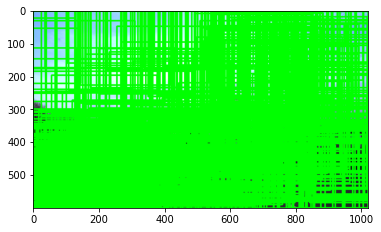

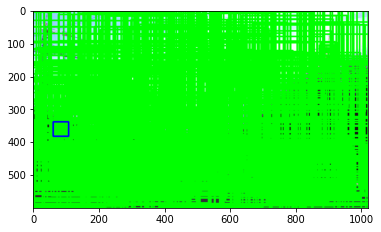

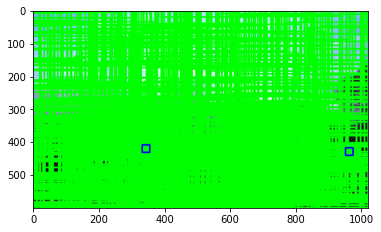

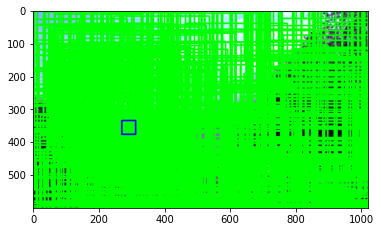

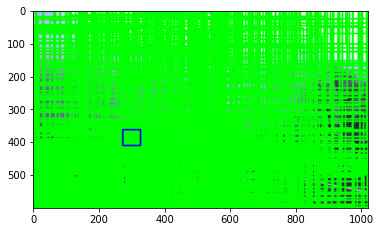

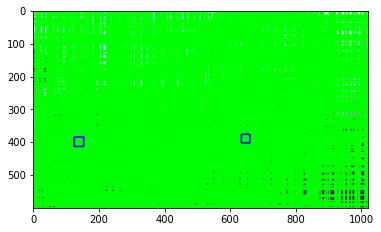

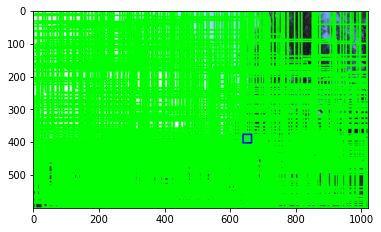

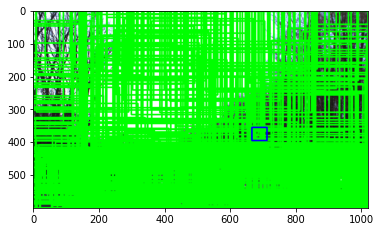

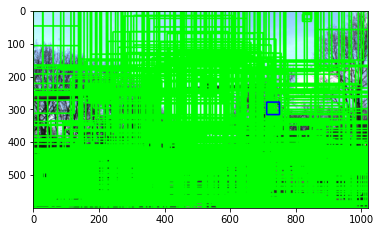

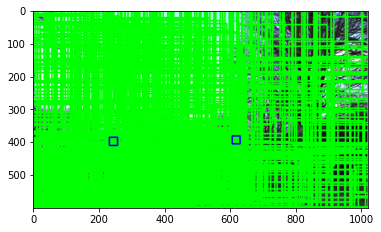

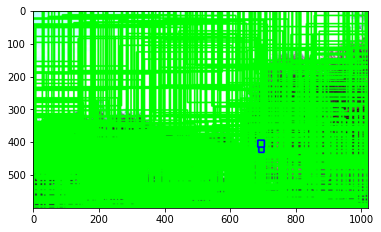

In [ ]:
counter = 0
for filename in test_images:
    # Draw predictions
    counter_2 = 0
    aux = test_images.get(filename)[0].copy()
    for bbox in test_pred.get(filename)[0]:
        cv2.rectangle(aux, (int(bbox[0]),int(bbox[1])), (int(bbox[2]),int(bbox[3])), (0,255,0), 3)
        counter_2 += 1
        if counter_2 > 750:
          break

    # Draw ground truth    
    if filename in test_files:
        for idx in [i for i, x in enumerate(test_files) if x == filename]:
            bbox = test_bboxes[idx]
            cv2.rectangle(aux, (int(bbox[0]),int(bbox[1])), (int(bbox[2]),int(bbox[3])), (255,0,0), 3)
            
    plt.imshow(cv2.cvtColor(aux, cv2.COLOR_BGR2RGB))
    plt.show()
    counter += 1
    if counter > 10:
        break

## Get dataset for background images
Commented because we already have the weights of the trained model. But this was how we extracted the background data.

In [ ]:
# !mkdir traffic_sign_images/
# !mkdir background_images/
# !rm -rf traffic_sign_images/*
# !rm -rf background_images/*

# MIN_SIZE_TAKE = 16
# MAX_SIZE_TAKE = 150
# IOU_THRESHOLD = 0.5

# BACKGROUND_TAKE = 150
# background_images_number_total = 0

# TRAFFIC_SIGN_TAKE = 120
# traffic_sign_images_number_total = len(os.listdir("traffic_sign_images/")) + 1
# print("Traffic signs before: " + str(traffic_sign_images_number_total))

# for filename in train_images: 
#     # Get ground truth boxes    
#     total_boxes_number = len(train_pred.get(filename)[0])
#     ground_truth_boxes = np.empty([0, 4])
#     image = train_images.get(filename)[0].copy()

#     background_images_number = 0

#     # Draw ground truth
#     if filename in train_files:
#         for idx in [i for i, x in enumerate(train_files) if x == filename]:
#             bbox = train_bboxes[idx]
#             gt_bbox_coordinates = [int(bbox[0]), int(bbox[1]), int(bbox[2]), int(bbox[3])]  
#             ground_truth_boxes = np.append(ground_truth_boxes, [gt_bbox_coordinates], axis = 0)
            
#             cropped_image = image[int(bbox[1]):int(bbox[3]), int(bbox[0]):int(bbox[2])]
#             cropped_image_resize = cv2.resize(cropped_image, IMAGE_SIZE)
#             cv2.imwrite("./traffic_sign_images/" + str(traffic_sign_images_number_total) + ".jpg", cropped_image_resize)
#             traffic_sign_images_number_total += 1 

#     # Get up to BOXES_PER_IMAGE_TAKE train bounding boxes for background
#     for bbox in train_pred.get(filename)[0]:
#       bbox_coordinates = [int(bbox[0]), int(bbox[1]), int(bbox[2]), int(bbox[3])]
#       cropped_image = image[int(bbox[1]):int(bbox[3]), int(bbox[0]):int(bbox[2])]
#       cropped_image_resize = cv2.resize(cropped_image, IMAGE_SIZE)

#        # Look for intersection over ground truth and bounding box
#       for ground_truth_bbox in ground_truth_boxes:
#         if (cropped_image.shape[0] >= MIN_SIZE_TAKE and cropped_image.shape[1] <= MAX_SIZE_TAKE):
#           iou = custom_iou(bbox_coordinates, ground_truth_bbox)
#           if (iou >= IOU_THRESHOLD):         
#             cv2.imwrite("./traffic_sign_images/" + str(traffic_sign_images_number_total) + ".jpg", cropped_image_resize)
#             traffic_sign_images_number_total += 1                 
#           elif (iou <= 0.2 and background_images_number < BACKGROUND_TAKE):
#             # Throw a dice to get a real random sample of background
#             if (random.random() > (BACKGROUND_TAKE / total_boxes_number)):
#               continue
#             else:
#               cv2.imwrite("./background_images/" + str(background_images_number_total) + ".jpg", cropped_image_resize)
#               background_images_number += 1      
#               background_images_number_total += 1     


# print("Traffic signs after: " + str(traffic_sign_images_number_total))

In [ ]:
# print(len(os.listdir("traffic_sign_images/")))
# print(len(os.listdir("background_images/")))

In [ ]:
# !zip -r background_images.zip background_images/
# !zip -r traffic_sign_images.zip traffic_sign_images/ 

## Get full GTSRB dataset

In [ ]:
# !wget https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB-Training_fixed.zip
# !unzip GTSRB-Training_fixed.zip

In [ ]:
# def readGTSRB(rootpath):
#     '''Reads traffic sign data for German Traffic Sign Recognition Benchmark.

#     Arguments: path to the traffic sign data, for example './GTSRB/Training'
#     Returns:   list of images, list of corresponding labels'''
#     images = [] # images
#     labels = [] # corresponding labels
#     # loop over all 42 classes
#     for c in range(0,43):
#         prefix = rootpath + '/' + format(c, '05d') + '/' # subdirectory for class
#         gtFile = open(prefix + 'GT-'+ format(c, '05d') + '.csv') # annotations file
#         gtReader = csv.reader(gtFile, delimiter=';') # csv parser for annotations file
#         next(gtReader) # skip header
#         # loop over all images in current annotations file
#         for row in gtReader:
#             image_resized = cv2.resize(plt.imread(prefix + row[0]), IMAGE_SIZE)      
#             images.append(image_resized) # the 1th column is the filename
#             labels.append(row[7]) # the 8th column is the label
#         gtFile.close()
#     return images, labels

In [ ]:
# gtrsrb_signs, gtrsrb_labels = readGTSRB('./GTSRB/Training')

## Train Background-Traffic Sign NN

In [ ]:
is_traffic_sign_model = get_traffic_sign_model(input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3), num_classes = 2)
is_traffic_sign_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              optimizer="Adamax", 
              metrics=['accuracy'])

is_traffic_sign_model.summary()

9412608/9406464 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 1, 1, 1280)        2257984   
_________________________________________________________________
global_max_pooling2d (Global (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,226,434
Non-trainable params: 34,112
_________________________________________________________________


#### Trained

In [ ]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=11oo8L3SxNpNgSlVlUcpkvMXme8no4Pzv' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=11oo8L3SxNpNgSlVlUcpkvMXme8no4Pzv" -O is_traffic_sign_model.zip && rm -rf /tmp/cookies.txt
!unzip is_traffic_sign_model.zip
is_traffic_sign_model.load_weights("is_traffic_sign_model/is_traffic_sign_model") 

--2020-04-03 20:14:06--  https://docs.google.com/uc?export=download&confirm=&id=11oo8L3SxNpNgSlVlUcpkvMXme8no4Pzv
Resolving docs.google.com (docs.google.com)... 74.125.28.139, 74.125.28.100, 74.125.28.102, ...
Connecting to docs.google.com (docs.google.com)|74.125.28.139|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0c-6c-docs.googleusercontent.com/docs/securesc/picjdpd687glpmmklge4pnc3917nb0sf/n7augu7l0el97jr4fhin774itabc1f62/1585944825000/08194845434926821008/08671441541892040373Z/11oo8L3SxNpNgSlVlUcpkvMXme8no4Pzv?e=download [following]
--2020-04-03 20:14:06--  https://doc-0c-6c-docs.googleusercontent.com/docs/securesc/picjdpd687glpmmklge4pnc3917nb0sf/n7augu7l0el97jr4fhin774itabc1f62/1585944825000/08194845434926821008/08671441541892040373Z/11oo8L3SxNpNgSlVlUcpkvMXme8no4Pzv?e=download
Resolving doc-0c-6c-docs.googleusercontent.com (doc-0c-6c-docs.googleusercontent.com)... 74.125.20.132, 2607:f8b0:400e:c07::84
Connecting to doc-0

In [ ]:
is_traffic_sign_model.predict(np.reshape(te_signs[11], [1, 32, 32, 3]))

array([[5.9279095e-13, 1.0000000e+00]], dtype=float32)

In [ ]:
loss, acc = is_traffic_sign_model.evaluate(te_signs, [1] * len(te_signs), verbose=1)
print(acc)

0.9861496


## Traffic Sign CNN
We suggest you train a “detector” CNN that determines whether a region proposal is a traffic sign.

Then use your traffic sign classification net to obtain the actual class. This is not the only approach to the problem, perhaps not even a good one. Feel free to follow your own thoughts. 

Bear in mind that both accuracy, in terms of mAP, and running time should be optimized in your solution. 

So, ideas to improve your classification performance
or speed-up the detection process, e.g. , e.g. use non-maximum-supression, some clever region proposal filter, etc... will make a difference


In [ ]:
traffic_sign_model = get_traffic_sign_model(input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3), num_classes = 43)
traffic_sign_model.compile(loss='categorical_crossentropy', 
              optimizer="Adam", 
              metrics=['accuracy'])

traffic_sign_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 1, 1, 1280)        2257984   
_________________________________________________________________
global_max_pooling2d_1 (Glob (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 43)                55083     
Total params: 2,313,067
Trainable params: 2,278,955
Non-trainable params: 34,112
_________________________________________________________________


In [ ]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1t5EjIEpV92-j-5Ihw3A-fa9nBzagF2L2' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1t5EjIEpV92-j-5Ihw3A-fa9nBzagF2L2" -O traffic_sign_model.zip && rm -rf /tmp/cookies.txt
!unzip traffic_sign_model.zip

--2020-04-03 20:14:34--  https://docs.google.com/uc?export=download&confirm=&id=1t5EjIEpV92-j-5Ihw3A-fa9nBzagF2L2
Resolving docs.google.com (docs.google.com)... 74.125.20.100, 74.125.20.113, 74.125.20.138, ...
Connecting to docs.google.com (docs.google.com)|74.125.20.100|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-08-2o-docs.googleusercontent.com/docs/securesc/9ucku4qpd0hdr13je97tpidrqr7a8ml3/ufr6o39f9egqhnc0ncn951gojm0nkh08/1585944825000/08194845434926821008/12278241027878920227Z/1t5EjIEpV92-j-5Ihw3A-fa9nBzagF2L2?e=download [following]
--2020-04-03 20:14:36--  https://doc-08-2o-docs.googleusercontent.com/docs/securesc/9ucku4qpd0hdr13je97tpidrqr7a8ml3/ufr6o39f9egqhnc0ncn951gojm0nkh08/1585944825000/08194845434926821008/12278241027878920227Z/1t5EjIEpV92-j-5Ihw3A-fa9nBzagF2L2?e=download
Resolving doc-08-2o-docs.googleusercontent.com (doc-08-2o-docs.googleusercontent.com)... 74.125.20.132, 2607:f8b0:400e:c07::84
Connecting to doc-0

In [ ]:
traffic_sign_model.load_weights("traffic_sign_model/traffic_sign_model")

In [ ]:
# traffic_sign_model_data = traffic_sign_model.fit(tr_signs, tr_labels,
#         batch_size=16,
#         epochs=10,
#         verbose=2,
#         validation_data=(va_signs, va_labels))

In [ ]:
# !mkdir traffic_sign_model
# is_traffic_sign_model.save_weights("traffic_sign_model/traffic_sign_model")
# !zip -r traffic_sign_model.zip traffic_sign_model

### Evaluate

In [ ]:
start = time()
loss, acc = traffic_sign_model.evaluate(te_signs, te_labels, verbose=1)
end = time()
print('CNN took ' + str(end - start) + ' seconds')
print('Test loss: ' + str(loss) + ' - Accuracy: ' + str(acc))

CNN took 3.670020341873169 seconds
Test loss: 0.12670243050583183 - Accuracy: 0.9833795


## Evaluation using Mean Average Precision

To evaluate your model you should use `https://github.com/Cartucho/mAP`. Following the guidelines of the mAP code we store the ground truth bboxes and labels in `mAP/input/ground-truth/`. Your results are stored in `mAP/input/detection-results/`. 

Note that in our code sign_class represents the predicted traffic sign label, confidence the confidence that the bbox has a traffic sign, and `bbox[...]` are the bbox co-ordinates.

In [ ]:
# Download the evaluation repository
!git clone https://github.com/angeligareta/mAP.git

# Create the directories
!rm -rf mAP/input/ground-truth
!rm -rf mAP/input/detection-results
!rm -rf mAP/input/images-optional
!rm -rf mAP/input
!rm -rf mAP/output/
!mkdir -p mAP/input/ground-truth
!mkdir -p mAP/input/detection-results

Cloning into 'mAP'...
remote: Enumerating objects: 13, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 893 (delta 4), reused 6 (delta 2), pack-reused 880
Receiving objects: 100% (893/893), 14.72 MiB | 18.74 MiB/s, done.
Resolving deltas: 100% (308/308), done.


In [ ]:
for filename in test_images:
    anns_ofs = open('mAP/input/ground-truth/' + filename[-9:-4:] + '.txt', 'w')
    if filename in test_files:
        for idx in [i for i, x in enumerate(test_files) if x == filename]:
            bbox = test_bboxes[idx]
            label = test_labels[idx]
            anns_ofs.write(str(label) + ' ' + str(bbox[0]) + ' ' + str(bbox[1]) + ' ' + str(bbox[2]) + ' ' + str(bbox[3]) + '\n')
    anns_ofs.close()

In [ ]:
# Do the NMS with the ones left
MIN_SIZE = 16
MAX_SIZE = 130
MAX_RATIO = 1.4 # omit it
MAX_IMG_OUTPUT = 6

IS_TRAFFIC_SIGN_PROB = 0.9999995 # TODO: Try changing values
SCORE_THRESHOLD = 0.965

IOU_THRESHOLD = 0.35

print("IS_TRAFFIC_SIGN_PROB: " + str(IS_TRAFFIC_SIGN_PROB))
print("SCORE_THRESHOLD: " + str(SCORE_THRESHOLD))
print("IOU_THRESHOLD: " + str(IOU_THRESHOLD))

# counter = 0
start = time()
previous_time = start
elapsed_times = []
for filename in test_images:
    # if counter > 15:
    #   break
    # counter += 1

    current_time = time()
    elapsed_time = round(current_time - previous_time, 3)
    elapsed_times.append(elapsed_time)
    previous_time = current_time

    time_left = round(mean(elapsed_times) * 300 - sum(elapsed_times), 3)
    percentage = round(sum(elapsed_times) / (sum(elapsed_times) + time_left), 2) if time_left != 0 else 0

    # Open the fsile where we are going to write the results
    prds_ofs = open('mAP/input/detection-results/' + filename[-9:-4:] + '.txt', 'w')
    print("Writing results to \"mAP/input/detection-results/{}.txt\"".format(filename[-9:-4:]) + "| Elapsed time: " + str(sum(elapsed_times) // 60) + " min | Esimated time left: " + str(time_left // 60) + " min | " +  str(percentage) + "%")

    boxes = np.empty([0, 4])
    classes = np.empty(0)
    scores = np.empty(0)

    # plt.imshow(test_images.get(filename)[0])
    # plt.show()

    # Save for the NMS the ones that pass the steps
    for bbox in test_pred.get(filename)[0]:
        coordinates = [int(bbox[0]), int(bbox[1]), int(bbox[2]), int(bbox[3])]

        # 1 - Omit bounding boxes that are not valid in size or position
        if (not isBoxValid(coordinates, MIN_SIZE, MAX_SIZE, MAX_RATIO)):
          continue 
         
        # Crop the Region Of Interest (ROI) from the original image
        roi = test_images.get(filename)[0][int(bbox[1]):int(bbox[3]), int(bbox[0]):int(bbox[2])]
        roi_resized = resize_roi(roi, IMAGE_SIZE)

        # 2 - Run background cnn to see if its traffic sign (1)
        is_traffic_sign_prob = is_traffic_sign_model.predict_proba(roi_resized).flatten()[1]
        if (is_traffic_sign_prob < IS_TRAFFIC_SIGN_PROB):
          continue          

        # 3 - Run your own detector and save each traffic sign classification
        # Skip predictions with small confidence
        sign_logits = traffic_sign_model.predict_proba(roi_resized).flatten()
        if sign_logits.max() < SCORE_THRESHOLD:
          continue

        # print(is_traffic_sign_prob)
        # print(sign_logits.max())
        # plt.imshow(roi)
        # plt.show()

        # Save the ones that passed the test
        boxes = np.append(boxes, [bbox], axis = 0)
        scores = np.append(scores, sign_logits.max())
        classes = np.append(classes, np.argmax(sign_logits))

    
    nms_indices = tf.image.non_max_suppression(boxes, scores, max_output_size=MAX_IMG_OUTPUT, iou_threshold=IOU_THRESHOLD, score_threshold=SCORE_THRESHOLD)
    selected_boxes_tensor = tf.gather(boxes, nms_indices)
    selected_scores_tensor = tf.gather(scores, nms_indices)
    selected_classes_tensor = tf.gather(classes, nms_indices)

    with tf.compat.v1.Session() as sess:
      selected_boxes, selected_scores, selected_classes = sess.run([selected_boxes_tensor, selected_scores_tensor, selected_classes_tensor])

    # Save the results for evaluation
    for i in range(0, selected_boxes.shape[0]):
      prds_ofs.write(str(int(selected_classes[i])) + ' ' + str(selected_scores[i]) + ' ' + str(selected_boxes[i][0]) + ' ' + str(selected_boxes[i][1]) + ' ' + str(selected_boxes[i][2]) + ' ' + str(selected_boxes[i][3]) + '\n')

    prds_ofs.close()

end = time()
print("Traffic sign detection took " + str(end - start) + " seconds")

IS_TRAFFIC_SIGN_PROB: 0.9999995
SCORE_THRESHOLD: 0.965
IOU_THRESHOLD: 0.35
Writing results to "mAP/input/detection-results/00600.txt"| Elapsed time: 0.0 min | Esimated time left: 0.0 min | 0%
Writing results to "mAP/input/detection-results/00601.txt"| Elapsed time: 0.0 min | Esimated time left: 15.0 min | 0.01%
Writing results to "mAP/input/detection-results/00602.txt"| Elapsed time: 0.0 min | Esimated time left: 22.0 min | 0.01%
Writing results to "mAP/input/detection-results/00603.txt"| Elapsed time: 0.0 min | Esimated time left: 26.0 min | 0.01%
Writing results to "mAP/input/detection-results/00604.txt"| Elapsed time: 0.0 min | Esimated time left: 26.0 min | 0.02%
Writing results to "mAP/input/detection-results/00605.txt"| Elapsed time: 0.0 min | Esimated time left: 27.0 min | 0.02%
Writing results to "mAP/input/detection-results/00606.txt"| Elapsed time: 0.0 min | Esimated time left: 29.0 min | 0.02%
Writing results to "mAP/input/detection-results/00607.txt"| Elapsed time: 0.0 min 

In [ ]:
# # # Do the NMS with the ones left
# IOU_THRESHOLD = 0.15
# SCORE_THRESHOLD = 0.9
# MAX_SIZE = 150
# MIN_SIZE = 16

# IS_TRAFFIC_SIGN_PROB = 0.6 # TODO: Try changing values

# gt_is_traffic_sign_probs = []
# gt_scores = []

# undetected = 0

# # counter = 0
# start = time()
# for filename in test_images:
#     # if counter > 15:
#     #   break
#     # counter += 1

#     # Open the fsile where we are going to write the results
#     prds_ofs = open('mAP/input/detection-results/' + filename[-9:-4:] + '.txt', 'w')
#     print("Writing results to \"mAP/input/detection-results/{}.txt\"".format(filename[-9:-4:]))

#     boxes = np.empty([0, 4])
#     classes = np.empty(0)
#     scores = np.empty(0)

#     # plt.imshow(test_images.get(filename)[0])
#     # plt.show()

#     gt_coordinates_array = []

#     if filename in test_files:
#           for idx in [i for i, x in enumerate(test_files) if x == filename]:
#               gt_bbox = test_bboxes[idx]
#               gt_coordinates_array.append([int(gt_bbox[0]), int(gt_bbox[1]), int(gt_bbox[2]), int(gt_bbox[3])])

#     ## Initialize boxes seen to 0
#     boxes_seen = [0] * len(gt_coordinates_array)

#     # Save for the NMS the ones that pass the steps
#     for bbox in test_pred.get(filename)[0]:      
#       index = 0
#       coordinates = [int(bbox[0]), int(bbox[1]), int(bbox[2]), int(bbox[3])]
#       ## Cheat to sea max score we can get
#       for gt_coordinates in gt_coordinates_array:
#         if (custom_iou(gt_coordinates, coordinates) >= 0.5):
#           # Crop the Region Of Interest (ROI) from the original image
#           roi = test_images.get(filename)[0][int(bbox[1]):int(bbox[3]), int(bbox[0]):int(bbox[2])]
#           is_traffic_sign_prob = is_traffic_sign_model.predict_proba(resize_roi(roi, IMAGE_SIZE)).flatten()[1]
#           sign_logits = traffic_sign_model.predict_proba(resize_roi(roi, IMAGE_SIZE)).flatten()

#           # print(is_traffic_sign_prob)
#           # print(sign_logits)

#           # Save parameters
#           gt_is_traffic_sign_probs.append(is_traffic_sign_prob)
#           gt_scores.append(sign_logits.max())

#           # Save the ones that passed the test
#           boxes = np.append(boxes, [bbox], axis = 0)
#           scores = np.append(scores, sign_logits.max())
#           classes = np.append(classes, np.argmax(sign_logits))

#           boxes_seen[index] = 1
#         index += 1

#     ## Count the ones we did not detect
#     for x in boxes_seen:
#       if (x == 0):
#        undetected += 1

#     nms_indices = tf.image.non_max_suppression(boxes, scores, max_output_size=TEST_POST_NMS_TOPK, iou_threshold=IOU_THRESHOLD, score_threshold=SCORE_THRESHOLD)
#     selected_boxes_tensor = tf.gather(boxes, nms_indices)
#     selected_scores_tensor = tf.gather(scores, nms_indices)
#     selected_classes_tensor = tf.gather(classes, nms_indices)

#     with tf.compat.v1.Session() as sess:
#       selected_boxes, selected_scores, selected_classes = sess.run([selected_boxes_tensor, selected_scores_tensor, selected_classes_tensor])

#     # Save the results for evaluation
#     for i in range(0, selected_boxes.shape[0]):
#       prds_ofs.write(str(int(selected_classes[i])) + ' ' + str(selected_scores[i]) + ' ' + str(selected_boxes[i][0]) + ' ' + str(selected_boxes[i][1]) + ' ' + str(selected_boxes[i][2]) + ' ' + str(selected_boxes[i][3]) + '\n')

#     prds_ofs.close()

# end = time()
# print("Traffic sign detection took " + str(end - start) + " seconds")

# print("Undetected " + str(undetected))

In [ ]:
# print("--Background prob--")
# print("Mean: " + str(mean(gt_is_traffic_sign_probs)))
# print("Median: " + str(median(gt_is_traffic_sign_probs)))
# print("Quartil 5: " + str(np.percentile(gt_is_traffic_sign_probs, 5)))
# print("Quartil 10: " + str(np.percentile(gt_is_traffic_sign_probs, 10)))
# print("Quartil 15: " + str(np.percentile(gt_is_traffic_sign_probs, 15)))
# print("Quartil 20: " + str(np.percentile(gt_is_traffic_sign_probs, 20)))
# print("Quartil 25: " + str(np.percentile(gt_is_traffic_sign_probs, 25)))

# print("--Traffic sign prob--")
# print("Mean: " + str(mean(gt_scores)))
# print("Median: " + str(median(gt_scores)))
# print("Min: " + str(min(gt_scores)))
# print("Max: " + str(max(gt_scores)))
# print("Quartil 5: " + str(np.percentile(gt_scores, 5)))
# print("Quartil 10: " + str(np.percentile(gt_scores, 10)))
# print("Quartil 15: " + str(np.percentile(gt_scores, 15)))
# print("Quartil 20: " + str(np.percentile(gt_scores, 20)))
# print("Quartil 25: " + str(np.percentile(gt_scores, 25)))

Show the predicted Trafic Signs in the first 10 images

In [ ]:
counter = 0
MAX_THICKNESS = 8
for filename in test_images:
    aux = test_images.get(filename)[0].copy()
    txt_filename = open('mAP/input/detection-results/' + filename[-9:-4:] + '.txt', 'r')
    f = open(txt_filename.name, "r")

    # counter_1 = 0 
    # Draw predictions
    previous_coordinates = [0, 0, 0, 0]
    for line in f.readlines():
      chunks = line.split(' ')
      class_id, confidence = int(chunks[0]), float(chunks[1])
      bb_left, bb_top, bb_right, bb_bottom = float(chunks[2]), float(chunks[3]), float(chunks[4]), float(chunks[5])
      print(confidence)
      coordinates = [bb_left, bb_top, bb_right, bb_bottom]
      cv2.rectangle(aux, (int(bb_left), int(bb_top)), (int(bb_right), int(bb_bottom)), (0,255,0), round(MAX_THICKNESS * (confidence - SCORE_THRESHOLD) / (1 - SCORE_THRESHOLD)))
      previous_coordinates = coordinates
    f.close()
    
    # Draw ground truth
    if filename in test_files:
        for idx in [i for i, x in enumerate(test_files) if x == filename]:
            bbox = test_bboxes[idx]
            cv2.rectangle(aux, (int(bbox[0]),int(bbox[1])), (int(bbox[2]),int(bbox[3])), (255,0,0), 4)
    plt.imshow(cv2.cvtColor(aux, cv2.COLOR_BGR2RGB))
    plt.show()
    counter += 1
    if counter > 55:
        break

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
%cd -q mAP
%run main.py -na -np
%cd -q ..

86.49% = 1 AP 
82.21% = 10 AP 
96.29% = 11 AP 
59.08% = 12 AP 
81.89% = 13 AP 
89.00% = 14 AP 
3.33% = 15 AP 
100.00% = 16 AP 
75.00% = 17 AP 
78.54% = 18 AP 
80.52% = 2 AP 
50.00% = 22 AP 
100.00% = 23 AP 
91.67% = 24 AP 
71.83% = 25 AP 
42.86% = 26 AP 
63.33% = 28 AP 
0.00% = 29 AP 
47.54% = 3 AP 
50.00% = 30 AP 
100.00% = 31 AP 
100.00% = 32 AP 
91.67% = 33 AP 
83.33% = 34 AP 
89.09% = 35 AP 
50.00% = 36 AP 
100.00% = 37 AP 
56.95% = 38 AP 
0.00% = 39 AP 
78.55% = 4 AP 
0.00% = 40 AP 
0.00% = 41 AP 
41.67% = 42 AP 
44.94% = 5 AP 
100.00% = 6 AP 
65.00% = 7 AP 
88.00% = 8 AP 
68.18% = 9 AP 
mAP = 65.97%
